In [1]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
from tqdm import tqdm
import imageio
import os
from scipy.stats.stats import pearsonr
from sklearn.metrics import matthews_corrcoef
# import higra as hg

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# mxnet1.6.0 env
import cv2
import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../resuneta/nn/loss')
sys.path.append('../../resuneta/models')
sys.path.append('../../')
sys.path.append('../MXNet-ResUNeta/')

from resunet_d6_causal_mtskcolor_ddist import *
from resunet_d7_causal_mtskcolor_ddist import *
from datasets import *

# Helper functions

In [3]:
def dice_coef(x, y):
    if type(x).__module__ == 'numpy':
        intersection = np.logical_and(x, y)
        return 2. * np.sum(intersection) / (np.sum(x) + np.sum(y))
    else:
        intersection = mx.ndarray.op.broadcast_logical_and(x, y)
        return 2. * mx.nd.sum(intersection) / (mx.nd.sum(x) + mx.nd.sum(y))

In [4]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

# Load model

In [5]:
# ==================== USER SETTINGS ==================== #
n_filters = 16
n_classes = 1
hsv_channels = 3
# country = 'senegal'
country = 'malawi'
# country = 'ghana-udry'

# === FRANCE MODELS === #
# model_name = 'resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/'
# file_name = '../experiments/france/sherrie10k/{}/model.params'.format(model_name)

# === PARTIAL LABELS FRANCE === #
model_name = 'resunet-d6_2019_10_nfilter-16_bs-8_lr-0.001_4x-downsampled_allfield_n6759/'
file_name = '../experiments/partial-france/{}/model.params'.format(model_name)

# === AFRICA FINE-TUNED === #
# if country == 'senegal':
#     model_name = 'resunet-d6_sepOctNov_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled_finetuned'
# elif country == 'malawi':
#     model_name = 'resunet-d6_janFebMar_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled_finetuned/'
# elif country == 'ghana-udry':
#     model_name = 'resunet-d6_febJunOct_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled_finetuned/'
# file_name = '../experiments/{}/{}/model.params'.format(country, model_name)
model = ResUNet_d6(_nfilters_init=n_filters, 
                   _NClasses=n_classes,
                   hsv_outchannels=hsv_channels)
gpu = 2
model.load_parameters(file_name, ctx=mx.gpu(gpu)) # mx.cpu())

# n_filters = 32
# n_classes = 1
# hsv_channels = 3
# model_name = 'resunet-d7_october_nfilter-32_bs-8_lr-0.001'
# file_name = '../experiments/france/hanAndBurak/{}/model.params'.format(model_name)
# model = ResUNet_d7(_nfilters_init=n_filters, 
#                    _NClasses=n_classes,
#                    hsv_outchannels=hsv_channels)
# gpu = 3
# model.load_parameters(file_name, ctx=mx.gpu(gpu))
# ======================================================= #

depth:= 0, nfilters: 16
depth:= 1, nfilters: 32
depth:= 2, nfilters: 64
depth:= 3, nfilters: 128
depth:= 4, nfilters: 256
depth:= 5, nfilters: 512
depth:= 6, nfilters: 256
depth:= 7, nfilters: 128
depth:= 8, nfilters: 64
depth:= 9, nfilters: 32
depth:= 10, nfilters: 16


# Run Africa images through model

In [6]:
# country = 'senegal'
# months = ['2019_{}'.format(str(x).zfill(2)) for x in np.arange(1, 13)]

# country = 'malawi'
# months = ['2018_{}'.format(str(x).zfill(2)) for x in np.arange(1, 13)]

country = 'ghana/udry'
months = ['2017_{}'.format(str(x).zfill(2)) for x in np.arange(1, 13)]

for month in months:
    print(month)
    print()
    # ==================== USER SETTINGS ==================== #
    image_directory = '../data/planet/{}/monthly_mosaics_renamed_clipped_merged/{}/'.format(country, month)
    batch_size = 8
    save_dir = '../results/{}/{}/planet/{}'.format(country, model_name, month)
    # ======================================================= #
    
    image_names = os.listdir(image_directory)
    dataset = PlanetDatasetNoLabels(image_directory, image_names=image_names, image_suffix='')
    dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
        os.makedirs(os.path.join(save_dir, 'extent_predictions'))

    # initialize metrics
    for batch_i, img in enumerate(dataloader):

        img = img.as_in_context(mx.gpu(gpu))
        logits, bound, dist, convc = model(img)

        extent_predicted_classes = mx.nd.ceil(logits[:,[0],:,:] - 0.5)
        boundary_predicted_classes = mx.nd.ceil(bound[:,[0],:,:] - 0.5)

        # Difference out borders
        diff = extent_predicted_classes - boundary_predicted_classes

        for i, diffed in enumerate(diff):
            diffed = np.maximum(diffed.asnumpy(), 0)

            # save predictions
            image_id = image_names[batch_i * batch_size + i].split('_')[0]
            np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i].asnumpy()[0])
            np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i].asnumpy()[0])

    #         print(val_names[batch_i * batch_size + i], mcc)
    #         fig, ax = plt.subplots(1,5, figsize=(18,4))
    #         ax[0].imshow(np.moveaxis(img.asnumpy()[i][:3], 0, -1) / 255.)
    #         ax[1].imshow(np.moveaxis(img.asnumpy()[i][3:6], 0, -1) / 255.)
    #         ax[2].imshow(np.moveaxis(img.asnumpy()[i][-3:], 0, -1) / 255.)
    #         ax[-2].imshow(instanceSeg)
    #         ax[-1].imshow(instanceSeg_pred)
    #         plt.show()
    #     break

2017_01

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10232_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09487_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07834_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04214_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07743_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/16762_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05762_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05342_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02890_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14145_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12153_20

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/06316_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03994_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08290_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12352_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/17869_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12353_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12243_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08417_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03231_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05436_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07942_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01679_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04895_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02880_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05650_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10053_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01369_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10253_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13394_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12442_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10355_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15563_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05765_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04431_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11823_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/06209_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13359_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03649_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/16189_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02345_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12446_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11444_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/06428_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04876_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01912_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15150_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07735_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11231_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02219_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02555_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03009_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04446_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12441_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08642_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09395_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14809_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14699_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09175_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05212_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09181_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02660_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01696_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05226_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10452_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08528_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11262_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03567_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11228_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08969_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03347_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10380_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01671_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11261_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01136_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/06208_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11482_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15960_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/00389_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03653_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07404_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15831_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03883_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12800_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12668_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04547_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03870_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11336_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11016_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02665_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09380_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10711_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07087_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09851_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07514_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/17757_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15673_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10472_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12690_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01567_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13036_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12784_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07083_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10251_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15586_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/17425_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05110_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05875_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01795_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/17210_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05093_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12262_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05219_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15028_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/17432_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14918_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/00279_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09485_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05633_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13613_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12574_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04591_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12474_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15853_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01694_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08183_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12918_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15370_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01591_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05233_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07527_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14923_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04436_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01676_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04676_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12451_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07980_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07976_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09284_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12799_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13697_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09711_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/16492_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11038_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04213_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09174_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09738_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01677_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14142_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13799_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/06099_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14360_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/17542_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12002_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07184_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15518_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04458_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15033_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12152_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04786_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01705_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01595_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09289_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15133_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05440_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15697_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07724_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15941_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/16559_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15890_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08403_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15016_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04917_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/06113_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/00280_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01243_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12364_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10604_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02114_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03101_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/00393_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02454_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13271_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13578_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/01678_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08531_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13367_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05651_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03119_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13699_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/00391_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10915_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07306_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12332_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10030_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02026_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09602_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13273_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12685_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/16299_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/04435_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/07726_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02216_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11481_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13701_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10510_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05094_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/16192_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09264_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14906_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08197_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/00385_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13143_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/06976_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/09045_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10136_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03988_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13501_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02228_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12778_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10785_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08860_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12004_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/02129_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14362_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/12356_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10801_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/08186_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/11114_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10917_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10163_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13687_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/14694_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/13283_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/05213_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/03538_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10601_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15366_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/10363_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15671_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/15481_2017_01.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_01/16190_2017_01.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03786_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05102_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12221_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01153_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15366_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11559_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/06220_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04587_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05980_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05428_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13921_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09492_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/00828_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16556_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13249_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02996_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/08960_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16760_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02446_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14808_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13358_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15783_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11025_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04762_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05553_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15561_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12571_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03546_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02979_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09736_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02555_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04213_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10271_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/17541_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02000_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14478_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16104_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05538_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14480_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/17208_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01574_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15251_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14582_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09958_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09628_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16324_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/17759_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03996_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09503_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/00827_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02119_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03881_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04541_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14257_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09846_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05440_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/17540_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12472_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01259_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12698_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13501_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02993_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12153_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/17209_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05027_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/08827_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05875_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05226_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04980_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13478_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09505_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01483_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01995_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/06315_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15255_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05520_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12681_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04554_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16180_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02216_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13587_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/00498_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11230_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02999_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03105_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01674_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02012_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15941_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02566_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13032_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12335_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11891_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12583_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03991_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01564_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14804_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11480_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02884_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14590_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03654_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13699_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11121_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02784_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16193_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12673_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10247_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10707_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/00719_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12560_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14362_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11148_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02869_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11823_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01787_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02782_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/00499_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15138_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02971_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/06090_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01684_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11897_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13172_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01809_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10916_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12798_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15342_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04651_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02775_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13700_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05541_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12801_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10488_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01811_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15675_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11023_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09815_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05437_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16980_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03994_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11553_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15592_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13468_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11822_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10710_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05249_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15698_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02007_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12885_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16992_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15891_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10355_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02345_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/00934_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13146_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02881_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16774_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14718_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14918_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/17102_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13147_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01237_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04760_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/00278_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03450_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/06113_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13143_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15014_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14919_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/08523_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02433_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12780_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/14927_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01136_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04804_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02109_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09284_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16189_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/08860_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15634_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16027_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/08968_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02868_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/17105_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13272_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10177_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15806_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05539_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16994_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10905_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04807_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12916_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16084_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03338_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02660_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16109_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10797_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03346_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04806_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/00392_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11040_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03648_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16383_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09917_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02235_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13504_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13063_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02551_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10253_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/07525_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/12784_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/09374_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/05650_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15853_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/06115_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13157_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/08182_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/04674_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01370_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02139_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/03230_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02977_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/13701_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11261_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/10052_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/15365_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/00933_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/02116_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/16069_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/17316_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/11700_2017_02.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_02/01703_2017_02.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/17538_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09045_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01248_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12808_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02448_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04806_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13157_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14588_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/03882_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10250_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11336_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09505_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12355_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04541_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01482_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11042_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08952_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14251_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14704_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10796_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08714_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12670_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04875_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16513_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05219_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12801_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02765_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/03099_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09392_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10674_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04223_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01241_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12336_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05090_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04323_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10685_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/06535_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01671_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15451_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01481_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02338_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/07194_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13283_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/07516_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02760_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15671_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05110_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16667_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11907_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15122_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12572_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05137_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/00280_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14828_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01373_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08301_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15231_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15481_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/07299_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02664_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10361_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15561_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14582_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/03786_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14692_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15125_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14498_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16492_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15862_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04696_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05424_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02890_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08846_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01675_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15832_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12672_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/06334_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10358_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04786_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/07963_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16079_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13358_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08934_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09845_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02793_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09379_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14142_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12691_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/00827_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02901_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/07514_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02446_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13697_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15368_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12243_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13799_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01902_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09176_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13155_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15033_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12552_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14364_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16271_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14717_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05246_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16073_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15697_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05657_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/03215_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15999_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14256_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04652_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09487_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16761_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04982_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05215_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02884_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01261_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12472_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12154_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15851_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01679_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/06099_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/03546_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01588_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04585_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/06416_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/06864_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11781_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14250_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16213_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02131_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05782_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16561_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02558_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/07408_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16654_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02794_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/06224_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09597_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02800_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13063_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08072_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02434_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08825_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13383_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/03651_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12682_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02229_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10928_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04458_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11823_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13171_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14916_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13265_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15595_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13486_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16493_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15301_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12001_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13031_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/17317_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13173_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15633_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09284_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02119_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13257_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04540_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08412_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05138_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15525_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08515_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/03108_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12916_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16324_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11027_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/03656_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11370_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04590_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15141_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12891_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01260_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/00284_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14257_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02442_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/00611_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10799_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/03790_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04876_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/02691_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08642_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04874_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09492_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13036_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10231_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13249_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/17319_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05214_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13140_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10138_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11553_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01136_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/07634_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10785_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04103_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11372_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/00391_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15782_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16603_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09705_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/07944_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/01479_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15631_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/14590_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08641_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/08413_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/11015_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/12783_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10559_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09712_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/05092_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/15266_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/00171_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/00173_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13282_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/13281_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/10691_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/04346_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16996_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/09264_2017_03.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_03/16632_2017_03.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12913_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02434_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07835_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02792_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02007_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07294_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/14480_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11591_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/00387_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13815_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/09063_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02455_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10382_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03119_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/14497_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02228_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10897_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01794_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16432_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/09383_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01694_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12685_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/15521_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05231_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02759_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08626_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12443_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/00171_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01369_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01898_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08634_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05783_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/06112_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03433_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13478_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13599_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05452_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11136_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05655_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10141_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05325_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16027_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11341_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10916_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08416_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10472_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01480_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02326_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/06318_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03877_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07305_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10601_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/00389_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/14699_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/09175_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13698_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04317_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12556_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/15630_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03341_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03547_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07833_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11820_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08195_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16179_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01684_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04695_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07082_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11668_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16668_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05766_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07083_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04324_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11262_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/00611_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13369_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01247_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12582_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04985_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10468_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02562_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12332_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05544_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08411_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10015_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/17321_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05329_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08072_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02775_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01346_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01135_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10797_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05332_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/14253_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04918_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16050_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02333_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03657_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/09602_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04476_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02565_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/17210_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13688_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07625_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08642_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/09921_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/15697_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04566_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12354_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05090_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16559_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13031_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08847_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03107_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13921_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/17104_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13382_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10253_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11337_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07634_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12912_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16884_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04104_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/14692_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/14814_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12152_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/17869_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/15260_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/15263_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11930_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05521_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04657_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/17867_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11781_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13687_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02117_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/06221_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03566_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08734_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/17430_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/17868_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04345_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11780_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13159_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02130_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11116_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01262_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12917_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05136_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16105_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13282_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12779_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07191_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10029_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04446_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/00494_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02003_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12461_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03648_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/06114_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05876_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04654_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05122_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10685_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02660_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02673_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16891_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05652_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01919_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16885_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13699_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16433_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11482_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07196_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04545_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/09285_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/09176_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/15341_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13157_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/17758_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02563_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08183_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05435_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11112_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11040_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02544_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02671_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10161_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01459_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08625_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13613_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03327_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/06097_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03878_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13027_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05520_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07735_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03988_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03105_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12478_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03897_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10028_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10466_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/05116_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07195_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/15999_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02435_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/14141_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02126_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/08641_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10179_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07403_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11891_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07845_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04764_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/13275_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/07834_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/17099_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01245_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/16992_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03994_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/14795_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/00280_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/03109_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/11559_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/01464_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/09392_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/10359_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/04914_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/02026_2017_04.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_04/12359_2017_04.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02670_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05323_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09181_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/17315_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08195_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01783_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10603_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01459_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00388_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07195_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05111_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16875_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11821_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09846_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02770_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/06206_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/17758_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16992_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02885_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04437_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04875_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00285_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09290_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15783_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08625_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02754_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01698_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11262_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03648_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12559_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08186_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12696_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01895_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09395_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12800_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04211_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08933_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11125_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04430_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01682_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09504_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01696_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01794_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16105_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12221_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12473_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08087_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16761_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15040_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15262_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02346_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10670_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13921_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10246_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04665_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13591_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02977_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09176_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02455_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03119_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02116_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12581_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05311_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09845_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04871_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07405_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04981_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15341_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10234_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07301_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02761_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10272_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/06090_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00603_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13038_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02863_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08637_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11449_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12685_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00059_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15033_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10560_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11932_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00390_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05538_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04676_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07633_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01043_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10801_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09383_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07407_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05246_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02557_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11146_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01348_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15850_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00171_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02778_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09264_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11893_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09920_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/06533_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09281_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09818_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/14923_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07409_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16560_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15916_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03996_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03544_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08295_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15518_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13033_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16136_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16447_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13154_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02974_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05231_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01243_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04999_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16446_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08843_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12471_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02784_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05137_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07086_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04457_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11895_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02995_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15263_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08306_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05649_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12572_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10178_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00060_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00611_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09601_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11005_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02128_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15521_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02228_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12464_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10669_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03326_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09171_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16271_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02004_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03538_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12686_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10806_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15150_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/14479_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13612_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15807_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07518_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10141_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16052_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10354_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03346_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03898_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02978_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11369_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04223_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08936_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07735_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13701_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15561_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09069_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/14366_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02782_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04807_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16671_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13595_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10895_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/14704_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03009_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01792_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/06113_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/06538_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/17316_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/10797_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07189_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/06099_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09489_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01904_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04548_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12474_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07526_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02555_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/14582_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02458_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12003_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01585_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/17540_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/14808_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03565_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00829_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02012_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/17954_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/06222_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/12461_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/09263_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05551_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15014_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01902_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02880_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11041_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11223_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04786_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13249_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02339_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/00394_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/04590_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08527_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01704_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/11929_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03567_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/08305_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/16982_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/14142_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07519_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/15520_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13257_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/05327_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/01246_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/03341_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/06098_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13046_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/13596_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/07734_2017_05.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_05/02765_2017_05.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14815_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/09374_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05428_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05215_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01477_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/00719_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13058_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05246_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13485_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10354_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05214_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02771_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02020_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04896_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12805_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04106_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/17323_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13591_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04207_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02885_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05782_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04997_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02022_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01466_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/06424_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/16104_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04567_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02764_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01695_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01355_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12478_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07630_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01478_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/06109_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/00714_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02334_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13595_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07082_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/09600_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/03120_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10179_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02882_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11113_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11040_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08515_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15595_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/00503_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11700_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/06116_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/03547_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13164_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15563_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08953_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08857_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14254_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15740_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10382_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07526_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10177_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07514_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04651_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07188_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15231_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10934_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04101_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12472_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05109_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11151_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14032_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/00381_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13274_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10160_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13162_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08747_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02230_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10070_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10915_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/16451_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13029_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04998_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/17209_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01685_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11557_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01480_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01995_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15265_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/06417_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13143_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/16302_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02346_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/06115_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15851_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/16299_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/06207_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04695_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08085_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13386_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02229_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/03995_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01792_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08528_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04778_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05436_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12697_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04766_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15260_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12804_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13030_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14144_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08421_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/03648_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15034_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12912_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10468_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08954_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14589_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07405_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04325_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/09845_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15586_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11558_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12808_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02884_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10381_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/17215_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/16652_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07962_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02781_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08516_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/00388_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01674_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13146_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08860_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12672_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04587_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02776_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12363_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05851_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05091_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14808_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12692_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13272_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05440_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10796_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14918_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12882_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13037_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01920_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02887_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12669_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11004_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04674_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/00385_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14828_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07300_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15917_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04555_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10016_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/17204_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15518_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12559_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/16246_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13701_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12780_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15561_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13039_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12152_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/06538_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/03543_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11449_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05111_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12573_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01698_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01587_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01264_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10471_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02662_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08073_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07404_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/17207_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02865_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01245_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12587_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11042_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07845_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/05425_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02125_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/00611_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02336_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04225_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07407_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08306_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/16183_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01589_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12463_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10692_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/16052_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02554_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01044_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/12442_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02652_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11781_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15134_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14145_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/07725_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/00495_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11591_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/09063_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/04437_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01566_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/11230_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15743_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/16982_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13283_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/09594_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/03788_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/14582_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/08193_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/02902_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15452_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10907_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/17210_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15854_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/06097_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10356_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10015_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/10465_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/01999_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/15960_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/03235_2017_06.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_06/13031_2017_06.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04101_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13705_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04104_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13146_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02671_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02974_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07406_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01563_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03218_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16074_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01136_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03456_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09174_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/14806_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08934_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10400_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01573_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15675_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09600_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07079_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07834_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11230_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13485_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09596_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09264_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12355_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/17101_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09064_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13164_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10707_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10561_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/05222_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04665_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16246_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11823_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16192_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01898_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08625_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13051_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12670_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01350_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02666_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01809_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09046_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11370_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10252_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15021_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/00611_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11023_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/14250_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04540_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02443_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02227_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10466_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02109_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03651_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16299_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12447_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02868_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15262_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04345_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04431_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01795_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10381_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08515_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10398_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01262_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01135_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12471_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12574_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12673_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/06975_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/17953_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13248_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15124_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10807_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11821_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02793_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15301_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16980_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07194_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02027_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/05541_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02011_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/06417_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15519_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03538_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10692_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09379_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/05876_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01574_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16667_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10230_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02996_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07294_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03662_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02754_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10053_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10465_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13037_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12776_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01792_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15151_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/00719_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13140_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/05987_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/05425_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10273_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07409_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12579_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02005_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08621_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13385_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08186_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11667_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15808_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10142_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12472_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13273_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15032_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10896_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04653_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03317_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15525_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/00059_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02783_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02325_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08090_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15036_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01671_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10671_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02000_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10231_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12805_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15560_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10271_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03789_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02566_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15138_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10894_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15745_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09819_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/05656_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07516_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15744_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/00385_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10895_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16669_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12902_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15634_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04984_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11482_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08194_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04228_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15482_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/14362_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03886_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02108_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04805_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07615_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16632_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04917_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04441_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13599_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11042_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13058_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08714_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/17091_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/14254_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02228_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11004_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03887_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16050_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02235_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10162_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07192_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09175_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15562_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02128_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04549_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02563_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08937_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/07942_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11779_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/05540_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08736_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/06113_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/05329_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10559_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12470_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09171_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15123_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11892_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03540_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/17430_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01591_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/02890_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15015_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04317_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16773_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11024_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/14585_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11152_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11337_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/00278_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01897_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03231_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12778_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12478_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09850_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/17433_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04542_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08184_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16887_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/17542_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13383_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/15251_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/08824_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12586_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/13358_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12797_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/11781_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/04548_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/14590_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/10598_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/12560_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/01587_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/03542_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/09594_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/16084_2017_07.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_07/14795_2017_07.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14926_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05782_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07184_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01563_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/08301_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16981_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02672_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01135_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13392_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15143_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10273_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15132_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10029_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10068_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02759_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12668_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12227_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04985_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15139_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14480_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12151_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10898_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07637_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05999_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16003_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02885_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04545_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04546_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01904_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10397_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13064_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02219_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13146_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/11558_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/00273_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15255_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15832_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03109_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05226_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10914_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02890_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01999_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09738_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10688_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/00932_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10452_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/11335_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13494_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12561_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05093_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13139_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04651_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10181_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15592_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03994_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/17314_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07309_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01892_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12587_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15588_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12262_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/08528_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14477_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01372_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/08860_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09491_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/06754_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09484_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16180_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/08417_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/17432_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/17213_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02336_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07525_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16986_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16872_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04322_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09601_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03317_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/08624_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09850_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13148_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02335_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03436_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03991_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13173_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12559_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07411_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/17431_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09845_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/08959_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/11134_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14032_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/06426_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16774_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12154_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05766_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/00381_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/00059_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04762_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07630_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03897_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13393_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07515_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02652_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12805_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15022_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12356_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05650_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09822_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14698_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/08734_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05896_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09487_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15343_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02778_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04540_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09816_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/17540_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12361_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07835_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15342_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/00503_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05655_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10139_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12698_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13689_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04760_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03679_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/08747_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05438_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05988_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15375_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/08290_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03995_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/06206_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14031_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/00382_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14035_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07734_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12696_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/06974_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03119_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10121_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16763_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15024_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10896_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05137_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14693_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16993_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03760_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15264_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02869_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16324_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07194_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02108_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16434_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13809_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01895_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03649_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05551_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01894_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03758_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13815_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15261_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13172_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15266_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02423_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12800_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/11026_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02684_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02776_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01478_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/11025_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14703_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/00717_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03650_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16667_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03010_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12463_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01464_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09178_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13143_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12360_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/11337_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03567_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05112_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02131_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07311_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03569_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01264_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10269_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/14582_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10246_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/17215_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/09710_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07628_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10472_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02326_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12588_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01812_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07405_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/00936_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/00937_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10234_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15481_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07845_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/10706_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/01243_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12694_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02020_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15563_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02009_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03218_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/16556_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05553_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07615_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04677_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/12331_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/03339_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15123_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04326_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/17102_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/06113_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02867_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/02675_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/13275_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/17316_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/07415_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/15521_2017_08.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/05122_2017_08.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15017_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06099_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03569_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03759_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01576_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12226_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/09290_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04211_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02119_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15366_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16557_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02760_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11151_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04696_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13698_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/17756_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03760_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02660_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03107_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03900_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02109_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03544_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02869_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13587_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/00282_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01241_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16885_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/14805_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/08074_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06113_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13265_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12004_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04225_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05327_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/09738_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04916_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01812_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05136_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11113_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04804_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02993_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12912_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02345_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16451_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11004_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02655_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05654_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04327_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02562_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10492_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11135_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13688_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02012_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03989_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01574_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/08197_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02555_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16083_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12694_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07626_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04876_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07633_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02564_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/17652_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03993_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02337_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02884_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/00387_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03679_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15486_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01698_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01672_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10564_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16995_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15893_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10068_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06754_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01913_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13810_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/08936_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16979_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01479_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03218_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12783_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06114_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/17205_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04874_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03540_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04806_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04098_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10691_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/00393_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07185_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15260_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10795_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16192_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05231_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04446_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12775_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15252_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16299_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10249_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07964_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07188_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12669_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15251_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06111_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12446_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02994_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01783_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12472_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12917_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01042_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07845_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02661_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01902_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05091_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10452_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02867_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04765_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11372_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12355_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12800_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05214_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10918_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10807_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15368_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/08626_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05656_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16303_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04336_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15371_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07726_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01245_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01997_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02108_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12562_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12571_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/17317_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16073_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/17101_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/00932_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/17320_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/09392_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05631_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03219_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/09285_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01920_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11449_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/08641_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06004_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11125_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10358_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/09486_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/08085_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12573_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15125_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07417_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/09173_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16051_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/04875_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06318_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/08937_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07615_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15342_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16105_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10907_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/09505_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10354_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01794_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06316_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16214_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06115_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10126_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12152_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03216_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15673_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/17434_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/08623_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13501_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01673_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16183_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/14360_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/17425_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/09373_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11892_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13164_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12005_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12335_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10688_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12913_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05221_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/06116_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15232_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15261_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15831_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11820_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/14031_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10269_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/00603_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03449_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/11262_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/00059_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/17539_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/05024_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01788_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16070_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02334_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13468_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/02754_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/01566_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13812_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13031_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16383_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16669_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12687_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15589_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/16193_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/12462_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13250_2017_09.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10357_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07305_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/07407_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/10581_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/13393_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/15262_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/08826_2017_09.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_09/03338_2017_09.tif
2017_10

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16193_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12559_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15134_20

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/00171_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03870_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15778_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/17095_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12798_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01810_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14608_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/11591_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14360_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13154_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02008_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16213_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13590_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16383_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09487_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08528_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02869_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02782_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04987_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15375_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13046_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15629_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03987_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12881_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04103_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01458_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04548_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10691_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04345_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04889_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10068_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02009_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04664_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16761_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/17205_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13599_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04677_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10688_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10254_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10918_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02890_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08084_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01700_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10560_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15139_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04100_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02990_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12462_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16027_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/00283_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14582_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/07637_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03235_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02338_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14589_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13038_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14915_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12791_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10247_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03325_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/17097_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13700_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15256_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10341_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/17099_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/11554_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01247_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06535_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04665_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04876_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13357_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10180_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14139_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09594_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02565_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02564_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14717_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13367_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/00170_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08184_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01586_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14917_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/05657_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12890_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/05875_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02684_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04327_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/11026_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/11004_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16003_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09263_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09171_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03011_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10245_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12913_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02979_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13502_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08935_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01154_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15851_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14704_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15040_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/17316_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09062_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02335_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/07421_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01793_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03877_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/07527_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10137_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03108_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03218_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15744_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01370_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/00279_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02325_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04225_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06537_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12471_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/07625_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06425_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/11228_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08959_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/00285_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03119_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/17206_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10358_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/00498_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12561_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/07519_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16991_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14703_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08414_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06536_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06416_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02553_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09486_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01045_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12468_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04804_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/11015_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02344_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13158_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04986_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10070_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10379_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/05895_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/07189_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14699_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10928_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08301_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04915_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09044_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/00276_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16432_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09628_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06203_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15123_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02775_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/07725_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15560_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/07409_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/05103_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08637_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/05340_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14719_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02116_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09485_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09816_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/00495_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/17204_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/12583_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06110_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08516_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06976_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09176_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14035_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14585_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13370_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/11369_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09380_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16981_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04431_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02114_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08404_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03099_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16557_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/08304_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15960_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14364_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/11121_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13374_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/00383_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13272_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06109_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16891_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01792_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/05094_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01243_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15586_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/01368_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13160_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02333_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02669_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15362_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02892_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09285_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/11559_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/06206_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/15916_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/16291_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/02660_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14815_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/10707_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/14584_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/04807_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/03887_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09705_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/13031_2017_10.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_10/09595_2017_10.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01045_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04986_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15016_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02989_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16189_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02112_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03656_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03347_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/13700_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/08633_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10251_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04446_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10451_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15480_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07976_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02778_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/14252_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/08634_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02560_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/06334_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/08626_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15363_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/06754_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16215_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/13276_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05329_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16543_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12477_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12354_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10706_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05452_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15633_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10602_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02109_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15265_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12039_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07196_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/17757_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03569_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10674_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/06535_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10601_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03345_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15831_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03449_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/00382_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02125_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16162_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07192_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/11230_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12243_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04805_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16294_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07516_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/17322_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10560_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/00171_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04105_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15889_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15342_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03433_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04871_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/11372_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07195_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12353_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10576_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16184_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10933_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03649_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/11119_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03883_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04549_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15375_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02883_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10581_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/09063_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10363_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16136_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01264_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07624_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07635_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/06416_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10466_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02442_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03101_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01893_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15255_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01674_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/13039_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05428_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15587_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02972_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/00932_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12885_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02771_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/06005_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/08404_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/17320_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05851_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/11120_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05430_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05652_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10929_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15783_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03217_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02326_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02761_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01477_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/11006_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/13376_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/08514_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/17210_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16995_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/09503_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16992_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/11907_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/08935_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/11447_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/13063_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05230_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10685_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07415_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/09921_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05103_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02127_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04981_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03551_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/06429_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05331_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10797_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05246_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02890_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04547_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/08641_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/06536_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12471_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/13370_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05987_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/09816_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16109_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12352_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01695_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02545_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16084_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10492_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07723_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15595_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/09178_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03107_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07845_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02881_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02544_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16982_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16884_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07634_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15485_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01241_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/11891_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01997_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07963_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/13275_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16434_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10381_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12478_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04476_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/06098_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10510_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/06864_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12364_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12571_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/05220_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07194_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02800_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04656_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01480_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01793_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10398_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/14142_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12254_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10898_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15411_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10249_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15959_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16632_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/00823_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03105_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/14916_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12802_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04876_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12000_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15259_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12462_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/14253_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/14250_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03993_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/09710_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/17091_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12153_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16670_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12341_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15031_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/16764_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15251_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15698_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10562_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/04651_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02454_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03900_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/03540_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/08624_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10141_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/11112_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/01373_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/15151_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02993_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/13467_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02423_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/10121_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/09850_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02228_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/12794_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/08824_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02219_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/07975_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/00273_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/17097_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/00285_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/14700_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/14362_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/17209_2017_11.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_11/02759_2017_11.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15341_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05103_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15031_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01782_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04874_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05137_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15940_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/09178_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04985_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01683_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04651_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10400_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05657_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15251_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/00169_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15369_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14031_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02111_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12775_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/09810_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02996_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13163_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/11341_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04441_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/00272_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01258_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13063_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07835_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/17208_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04323_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13140_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01795_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10359_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08633_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15363_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15595_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13028_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01678_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14584_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01698_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01481_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02126_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01796_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16995_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10141_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10030_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12352_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05435_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12802_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04785_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10934_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16213_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15853_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12586_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05219_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12039_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04223_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14366_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08935_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16762_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03883_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/17097_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01896_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02423_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04324_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16027_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08718_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12341_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15629_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15741_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07515_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10907_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15478_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05116_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08960_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/09818_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07309_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10140_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13035_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12111_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07976_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15024_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02108_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16105_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16104_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14478_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12694_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03105_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02800_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13596_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16432_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16602_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02566_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10916_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07295_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05877_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15525_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02664_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/09502_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12243_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05551_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/17758_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/17095_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05520_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15365_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12587_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08304_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16324_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02219_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05109_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08293_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07406_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/11260_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05894_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/00494_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05331_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16300_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03340_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10914_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/09712_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02453_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10151_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15256_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/06097_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/11670_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01367_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03790_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12254_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01590_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15890_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04321_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16446_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/11023_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04764_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05762_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04325_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03788_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12251_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12552_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02662_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03679_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02663_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08402_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13058_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05341_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12688_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12263_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/17317_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15587_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/06535_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/06199_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10026_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02446_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/17542_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07310_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/11223_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01808_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03650_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02761_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/11711_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10797_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13486_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03450_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08936_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14362_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10270_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07412_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16885_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02890_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14794_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13272_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02026_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16302_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02974_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02130_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02766_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07411_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02555_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01672_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14254_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/06116_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08311_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12668_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14477_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04333_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07403_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16294_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10272_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07085_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04208_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03231_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04696_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14719_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01700_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10896_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13591_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02551_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12559_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/03009_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05655_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05540_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04456_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05875_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13154_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/06222_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04207_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/13159_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05896_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08843_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10581_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16215_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/15959_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/11041_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/01783_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16559_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/14256_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/11336_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05741_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02661_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/07311_2017_12.tif

../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05654_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/08301_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/05233_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/10929_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/04457_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/12355_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/02327_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/06091_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/16492_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/09845_2017_12.tif
../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_12/11025_2017_12.tif

## Validation metrics

### MCC

In [5]:
# metrics on partial labels
# country = 'senegal'
# country = 'malawi'
country = 'ghana-udry'
codes_to_keep = [1]
batch_size = 8
boundary_kernel_size = (2,2)
ctx_name = 'gpu'
gpu_id = 2

if country == 'senegal':
    splits_path = '../data/splits/senegal_planetImagery_splits_tiles_overlap.csv'
elif country == 'malawi':
    splits_path = '../data/splits/malawi_planetImagery_splits_tiles_overlap.csv'
elif country == 'ghana-udry':
    splits_path = '../data/splits/ghana-udry_planetImagery_splits_tiles_overlap.csv'
splits_df = pd.read_csv(splits_path, dtype=str)

# get all img and labels
all_img_names = []
all_label_names = []

if country == 'senegal' or country == 'malawi':
    img_dir = '../data/planet/{}/monthly_mosaics_renamed_clipped_merged/'.format(country)
    label_dir = '../data/planet/{}/extent_labels/'.format(country)
elif country == 'ghana-udry':
    img_dir = '../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/'
    label_dir = '../data/planet/ghana/udry/extent_labels/'

label_folder_imgs = sorted(os.listdir(label_dir))
if country == 'senegal':
    months = ['2019_09', '2019_10', '2019_11']
elif country == 'malawi':
    months = ['2018_01', '2018_02', '2018_03']
elif country == 'ghana-udry':
    months = ['2017_02', '2017_06', '2017_10']
    
for month in months:
    for label_name in label_folder_imgs:
        img_name = label_name.split('.')[0] + '_' + month + '.tif'
        img_path = os.path.join(img_dir, month, img_name)
        all_img_names.append(img_path)
        label_path = os.path.join(label_dir, label_name)
        all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[0])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names = all_images[all_images['fold'] == 'train']['img_path'].values
val_names = all_images[all_images['fold'] == 'val']['img_path'].values
test_names = all_images[all_images['fold'] == 'test']['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names_label = all_labels[all_labels['fold'] == 'train']['label_path'].values
val_names_label = all_labels[all_labels['fold'] == 'val']['label_path'].values
test_names_label = all_labels[all_labels['fold'] == 'test']['label_path'].values

train_dataset = PlanetDatasetWithClassesFullPathsMasked(
    fold='train', 
    image_names=train_names, 
    label_names=train_names_label, 
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)
val_dataset = PlanetDatasetWithClassesFullPathsMasked(
    fold='val', 
    image_names=val_names, 
    label_names=val_names_label, 
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)

train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = gluon.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# initialize metrics
if ctx_name == 'cpu':
    ctx = mx.cpu()
else:
    ctx = mx.gpu(gpu_id)

image_mccs = {'train': [], 'val': []}

# validation set
for fold in ['train', 'val']: # 'train', 
    print("Evaluating {} set".format(fold))
    mcc = mx.metric.MCC()
    
    if fold == 'train':
        fold_dataloader = train_dataloader
    elif fold == 'val':
        fold_dataloader = val_dataloader
        
    for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(
        tqdm(fold_dataloader)):

        img = img.as_in_context(ctx)
        extent = extent.as_in_context(ctx)
        boundary = boundary.as_in_context(ctx)
        distance = distance.as_in_context(ctx)
        hsv = hsv.as_in_context(ctx)
        mask = mask.as_in_context(ctx)
        nonmask = mx.nd.ones(extent.shape).as_in_context(ctx)

        logits, bound, dist, convc = model(img)
        
        # update metrics based on every batch
        # mask out unlabeled pixels            
        logits_reshaped = logits.reshape((logits.shape[0], -1))
        extent_reshaped = extent.reshape((extent.shape[0], -1))
        mask_reshaped = mask.reshape((mask.shape[0], -1))
        
        nonmask_idx = mx.np.nonzero(mask_reshaped.as_np_ndarray())
        nonmask_idx = mx.np.stack(nonmask_idx).as_nd_ndarray().as_in_context(ctx)
        logits_masked = mx.nd.gather_nd(logits_reshaped, nonmask_idx)
        extent_masked = mx.nd.gather_nd(extent_reshaped, nonmask_idx)
        
        probabilities = mx.nd.stack(1 - logits_masked, logits_masked, axis=1)
        mcc.update(extent_masked, probabilities)

        for i in range(img.shape[0]):
            if np.sum(mask[i][0].asnumpy()) == 0:
                image_mccs[fold].append(np.nan)
            else:
                nonmask_idx = mx.np.nonzero(mask[i][0].as_np_ndarray())
                nonmask_idx = mx.np.stack(nonmask_idx).as_nd_ndarray().as_in_context(ctx)
                logits_masked = mx.nd.gather_nd(logits[i][0], nonmask_idx)
                extent_masked = mx.nd.gather_nd(extent[i][0], nonmask_idx)
                logits_masked_np = np.array(logits_masked.asnumpy() > 0.5, dtype='uint8')
                extent_masked_np = extent_masked.asnumpy()

                img_mcc = matthews_corrcoef(extent_masked_np, logits_masked_np)
                image_mccs[fold].append(img_mcc)
                
    print("  MCC = {}".format(mcc.get()[1]))

  0%|          | 0/451 [00:00<?, ?it/s]

Evaluating train set


  1%|▏         | 6/451 [00:04<05:36,  1.32it/s]/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
  0%|          | 0/110 [00:00<?, ?it/s]

  MCC = 0.17102725935610366
Evaluating val set


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]

  MCC = 0.17720188372847492


In [7]:
results = pd.DataFrame({
    'image_path': list(train_names) + list(val_names),
    'mcc': image_mccs['train'] + image_mccs['val'],
    'fold': ['train'] * len(train_names) + ['val'] * len(val_names)
})
results['image_id'] = results['image_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('_').apply(lambda x: x[0])
results['month'] = results['image_path'].str.split('/').apply(lambda x: x[-2])

In [8]:
results[results['fold'] == 'val'].mean()

mcc         0.181533
image_id         inf
month            inf
dtype: float64

In [9]:
results.head()

image_path       mcc   fold  \
0  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.322916  train   
1  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.500312  train   
2  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.429873  train   
3  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.259320  train   
4  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.537135  train   

  image_id    month  
0    00272  2017_02  
1    00273  2017_02  
2    00381  2017_02  
3    00382  2017_02  
4    00383  2017_02

In [10]:
# pc1 = pd.read_csv('../results/senegal/resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/image_PC1.csv')
# pc1 = pd.read_csv('../results/malawi/resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/image_PC1.csv')
pc1 = pd.read_csv('../results/ghana/udry/resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/image_PC1.csv')
pc1['image_id'] = pc1['image_id'].astype(str).str.zfill(5)

In [11]:
merged = results.merge(pc1, on=['image_id', 'month'], how='left')

In [12]:
merged.head()

image_path       mcc   fold  \
0  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.322916  train   
1  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.500312  train   
2  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.429873  train   
3  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.259320  train   
4  ../data/planet/ghana/udry/monthly_mosaics_rena...  0.537135  train   

  image_id    month         image_name       PC1  
0    00272  2017_02  00272_2017_02.tif -0.250673  
1    00273  2017_02  00273_2017_02.tif  0.126828  
2    00381  2017_02  00381_2017_02.tif  1.569054  
3    00382  2017_02  00382_2017_02.tif  0.026403  
4    00383  2017_02  00383_2017_02.tif  0.850485

### Senegal

#### Before fine-tuning

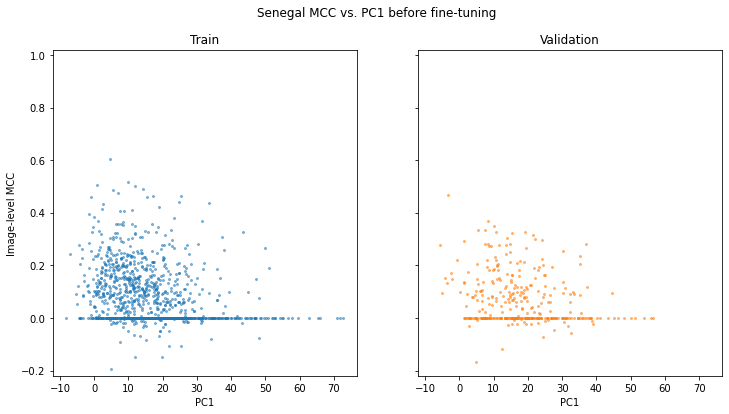

In [12]:
merged_clean = merged.dropna(subset=['mcc'], axis=0)

ncol = 2
fig, ax = plt.subplots(1, ncol, figsize=(12, 6), sharex=True, sharey=True)
ax[0].plot(merged_clean[merged_clean['fold'] == 'train']['PC1'],
           merged_clean[merged_clean['fold'] == 'train']['mcc'], 'o', ms=2, alpha=0.5, color='C0')
ax[1].plot(merged_clean[merged_clean['fold'] == 'val']['PC1'],
           merged_clean[merged_clean['fold'] == 'val']['mcc'], 'o', ms=2, alpha=0.5, color='C1')
ax[0].set_title('Train')
ax[1].set_title('Validation')

for i in range(ncol):
    ax[i].set_xlabel('PC1')
    if i == 0:
        ax[i].set_ylabel('Image-level MCC')
    ax[i].set_ylim([-0.22, 1.02])
fig.suptitle('{} MCC vs. PC1 before fine-tuning'.format(country.capitalize()))
plt.show()

#### After fine-tuning

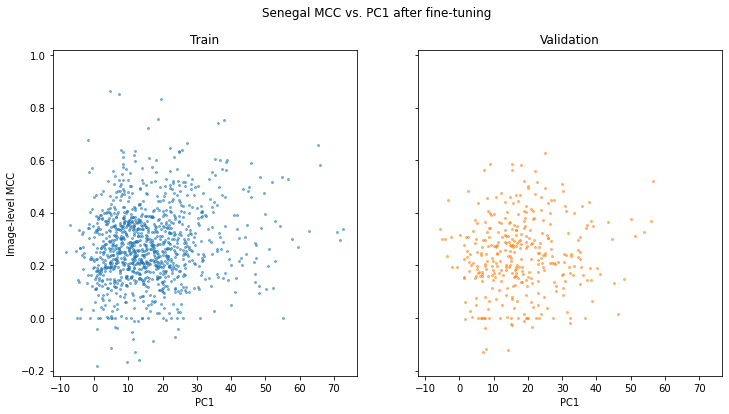

In [99]:
merged_clean = merged.dropna(subset=['mcc'], axis=0)

ncol = 2
fig, ax = plt.subplots(1, ncol, figsize=(12, 6), sharex=True, sharey=True)
ax[0].plot(merged_clean[merged_clean['fold'] == 'train']['PC1'],
           merged_clean[merged_clean['fold'] == 'train']['mcc'], 'o', ms=2, alpha=0.5, color='C0')
ax[1].plot(merged_clean[merged_clean['fold'] == 'val']['PC1'],
           merged_clean[merged_clean['fold'] == 'val']['mcc'], 'o', ms=2, alpha=0.5, color='C1')
ax[0].set_title('Train')
ax[1].set_title('Validation')

for i in range(ncol):
    ax[i].set_xlabel('PC1')
    if i == 0:
        ax[i].set_ylabel('Image-level MCC')
    ax[i].set_ylim([-0.22, 1.02])
fig.suptitle('{} MCC vs. PC1 after fine-tuning'.format(country.capitalize()))
plt.show()

### Malawi

#### Before fine-tuning

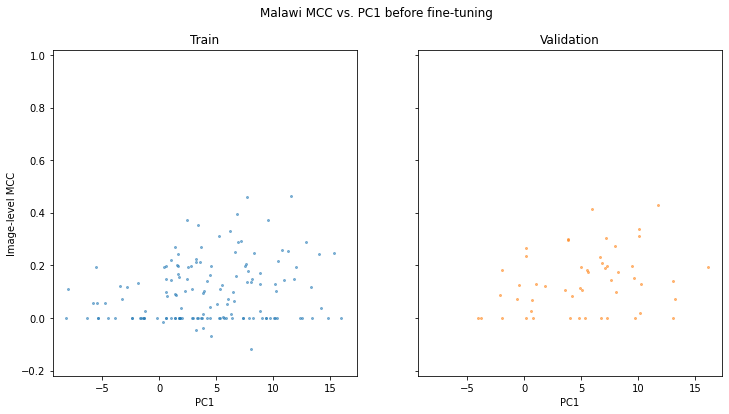

In [11]:
merged_clean = merged.dropna(subset=['mcc'], axis=0)

ncol = 2
fig, ax = plt.subplots(1, ncol, figsize=(12, 6), sharex=True, sharey=True)
ax[0].plot(merged_clean[merged_clean['fold'] == 'train']['PC1'],
           merged_clean[merged_clean['fold'] == 'train']['mcc'], 'o', ms=2, alpha=0.5, color='C0')
ax[1].plot(merged_clean[merged_clean['fold'] == 'val']['PC1'],
           merged_clean[merged_clean['fold'] == 'val']['mcc'], 'o', ms=2, alpha=0.5, color='C1')
ax[0].set_title('Train')
ax[1].set_title('Validation')

for i in range(ncol):
    ax[i].set_xlabel('PC1')
    if i == 0:
        ax[i].set_ylabel('Image-level MCC')
    ax[i].set_ylim([-0.22, 1.02])
fig.suptitle('{} MCC vs. PC1 before fine-tuning'.format(country.capitalize()))
plt.show()

#### After fine-tuning

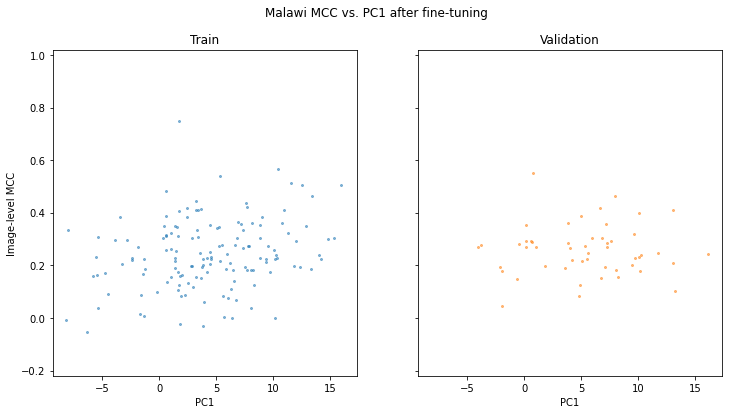

In [15]:
merged_clean = merged.dropna(subset=['mcc'], axis=0)

ncol = 2
fig, ax = plt.subplots(1, ncol, figsize=(12, 6), sharex=True, sharey=True)
ax[0].plot(merged_clean[merged_clean['fold'] == 'train']['PC1'],
           merged_clean[merged_clean['fold'] == 'train']['mcc'], 'o', ms=2, alpha=0.5, color='C0')
ax[1].plot(merged_clean[merged_clean['fold'] == 'val']['PC1'],
           merged_clean[merged_clean['fold'] == 'val']['mcc'], 'o', ms=2, alpha=0.5, color='C1')
ax[0].set_title('Train')
ax[1].set_title('Validation')

for i in range(ncol):
    ax[i].set_xlabel('PC1')
    if i == 0:
        ax[i].set_ylabel('Image-level MCC')
    ax[i].set_ylim([-0.22, 1.02])
fig.suptitle('{} MCC vs. PC1 after fine-tuning'.format(country.capitalize()))
plt.show()

### Ghana Udry

#### Before fine-tuning

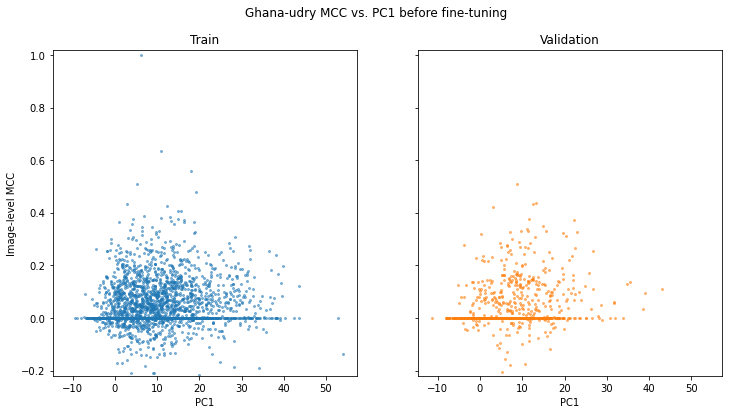

In [14]:
merged_clean = merged.dropna(subset=['mcc'], axis=0)

ncol = 2
fig, ax = plt.subplots(1, ncol, figsize=(12, 6), sharex=True, sharey=True)
ax[0].plot(merged_clean[merged_clean['fold'] == 'train']['PC1'],
           merged_clean[merged_clean['fold'] == 'train']['mcc'], 'o', ms=2, alpha=0.5, color='C0')
ax[1].plot(merged_clean[merged_clean['fold'] == 'val']['PC1'],
           merged_clean[merged_clean['fold'] == 'val']['mcc'], 'o', ms=2, alpha=0.5, color='C1')
ax[0].set_title('Train')
ax[1].set_title('Validation')

for i in range(ncol):
    ax[i].set_xlabel('PC1')
    if i == 0:
        ax[i].set_ylabel('Image-level MCC')
    ax[i].set_ylim([-0.22, 1.02])
fig.suptitle('{} MCC vs. PC1 before fine-tuning'.format(country.capitalize()))
plt.show()

#### After fine-tuning

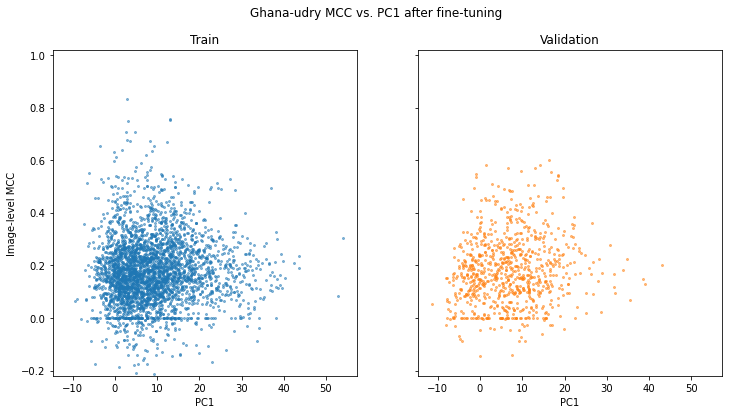

In [13]:
merged_clean = merged.dropna(subset=['mcc'], axis=0)

ncol = 2
fig, ax = plt.subplots(1, ncol, figsize=(12, 6), sharex=True, sharey=True)
ax[0].plot(merged_clean[merged_clean['fold'] == 'train']['PC1'],
           merged_clean[merged_clean['fold'] == 'train']['mcc'], 'o', ms=2, alpha=0.5, color='C0')
ax[1].plot(merged_clean[merged_clean['fold'] == 'val']['PC1'],
           merged_clean[merged_clean['fold'] == 'val']['mcc'], 'o', ms=2, alpha=0.5, color='C1')
ax[0].set_title('Train')
ax[1].set_title('Validation')

for i in range(ncol):
    ax[i].set_xlabel('PC1')
    if i == 0:
        ax[i].set_ylabel('Image-level MCC')
    ax[i].set_ylim([-0.22, 1.02])
fig.suptitle('{} MCC vs. PC1 after fine-tuning'.format(country.capitalize()))
plt.show()

## Threshold tuning

### Senegal

In [ ]:
year = 2019
img_dir = '../data/planet/senegal/monthly_mosaics_renamed_clipped_merged/'
img_names = os.listdir(os.path.join(img_dir, '{}_01'.format(year)))
random_image_name = np.random.choice(img_names)
month_dirs = ['{}_{}'.format(year, str(x+1).zfill(2)) for x in range(12)]

fig, ax = plt.subplots(4, 6, figsize=(24, 16))
for m, month in enumerate(month_dirs):
    random_image = imageio.imread(os.path.join(img_dir, month, random_image_name + '_' + month + '.tif'))[:256,:256,:3]
    img = np.moveaxis(np.expand_dims(random_image, 0), -1, 1)
    img = mx.nd.array(img).as_in_context(mx.gpu(gpu))
    logits, bound, dist, convc = model(img)
    
    i = m // 6
    j = m % 6
    ax[i,j].imshow(random_image)
    ax[i,j].set_title('Planet image {}'.format(month))
    
    ax[i+2,j].imshow(logits.asnumpy()[0][0], vmin=0, vmax=1, cmap='Greys_r')
    ax[i+2,j].set_title('Prediction')
    
plt.tight_layout()
plt.show()

## Visualize results

### Multi-month model Sherrie 10k

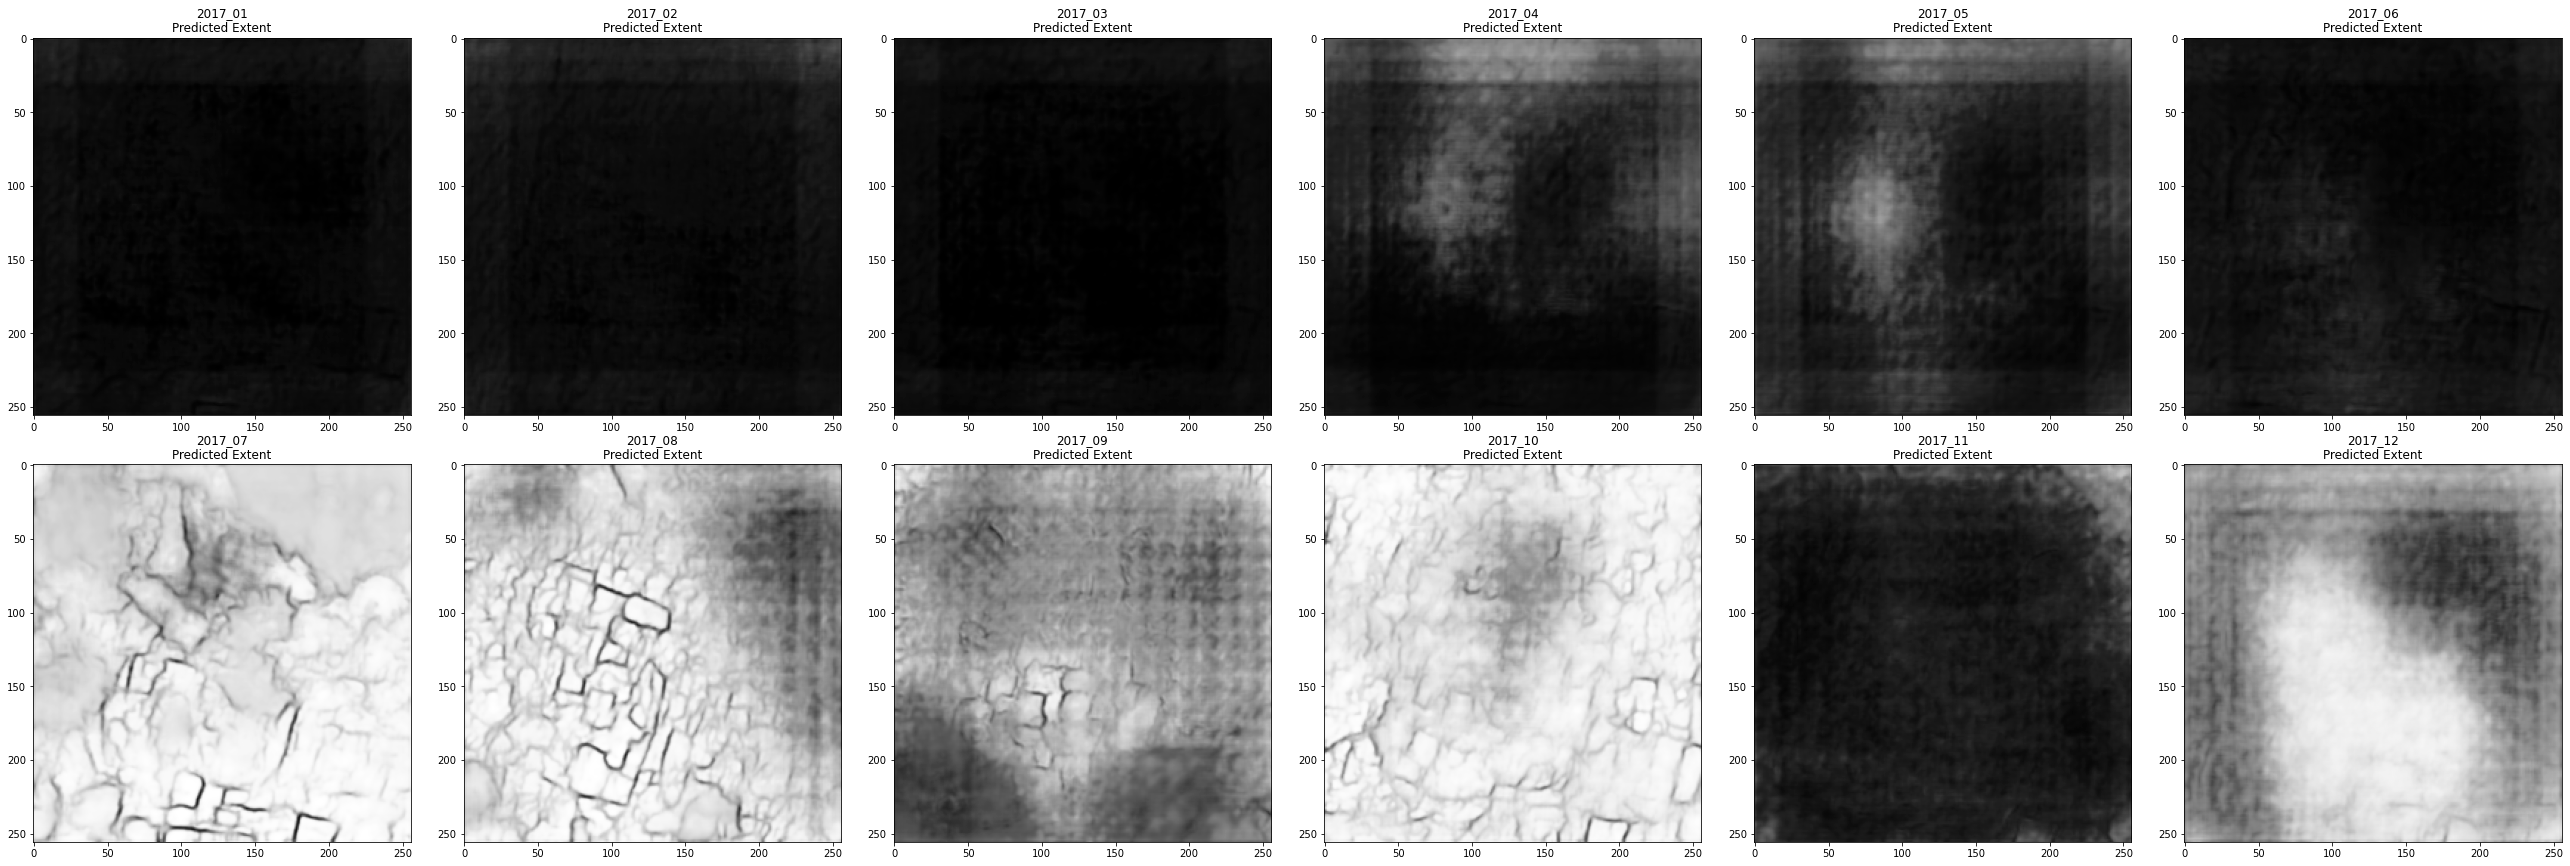

In [41]:
country = 'ghana/udry'
model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_4x-downsampled/'
results_dir = '../results/{}/{}/planet/'.format(country, model_name)
planet_dir = '../data/planet/{}/monthly_mosaics_renamed_clipped_merged/'.format(country)
month_dirs = sorted(os.listdir(planet_dir))

img_csv = pd.read_csv('../data/planet/{}/bbox_tiles_overlap.csv'.format(country), dtype=str)
random_image_name = np.random.choice(img_csv['image_id'].values)

fig, ax = plt.subplots(2, 6, figsize=(36,12))
for m, month in enumerate(month_dirs):
    example_extent = np.load(os.path.join(results_dir, month, 'extent_predictions/{}.npy'.format(random_image_name)))
    example_boundary = np.load(os.path.join(results_dir, month, 'boundary_predictions/{}.npy'.format(random_image_name)))
    
    i = m // 6
    j = m % 6
    ax[i,j].imshow(example_extent, vmin=0, vmax=1, cmap='Greys_r')
    ax[i,j].set_title('{}\nPredicted Extent'.format(month))

plt.tight_layout()
plt.show()

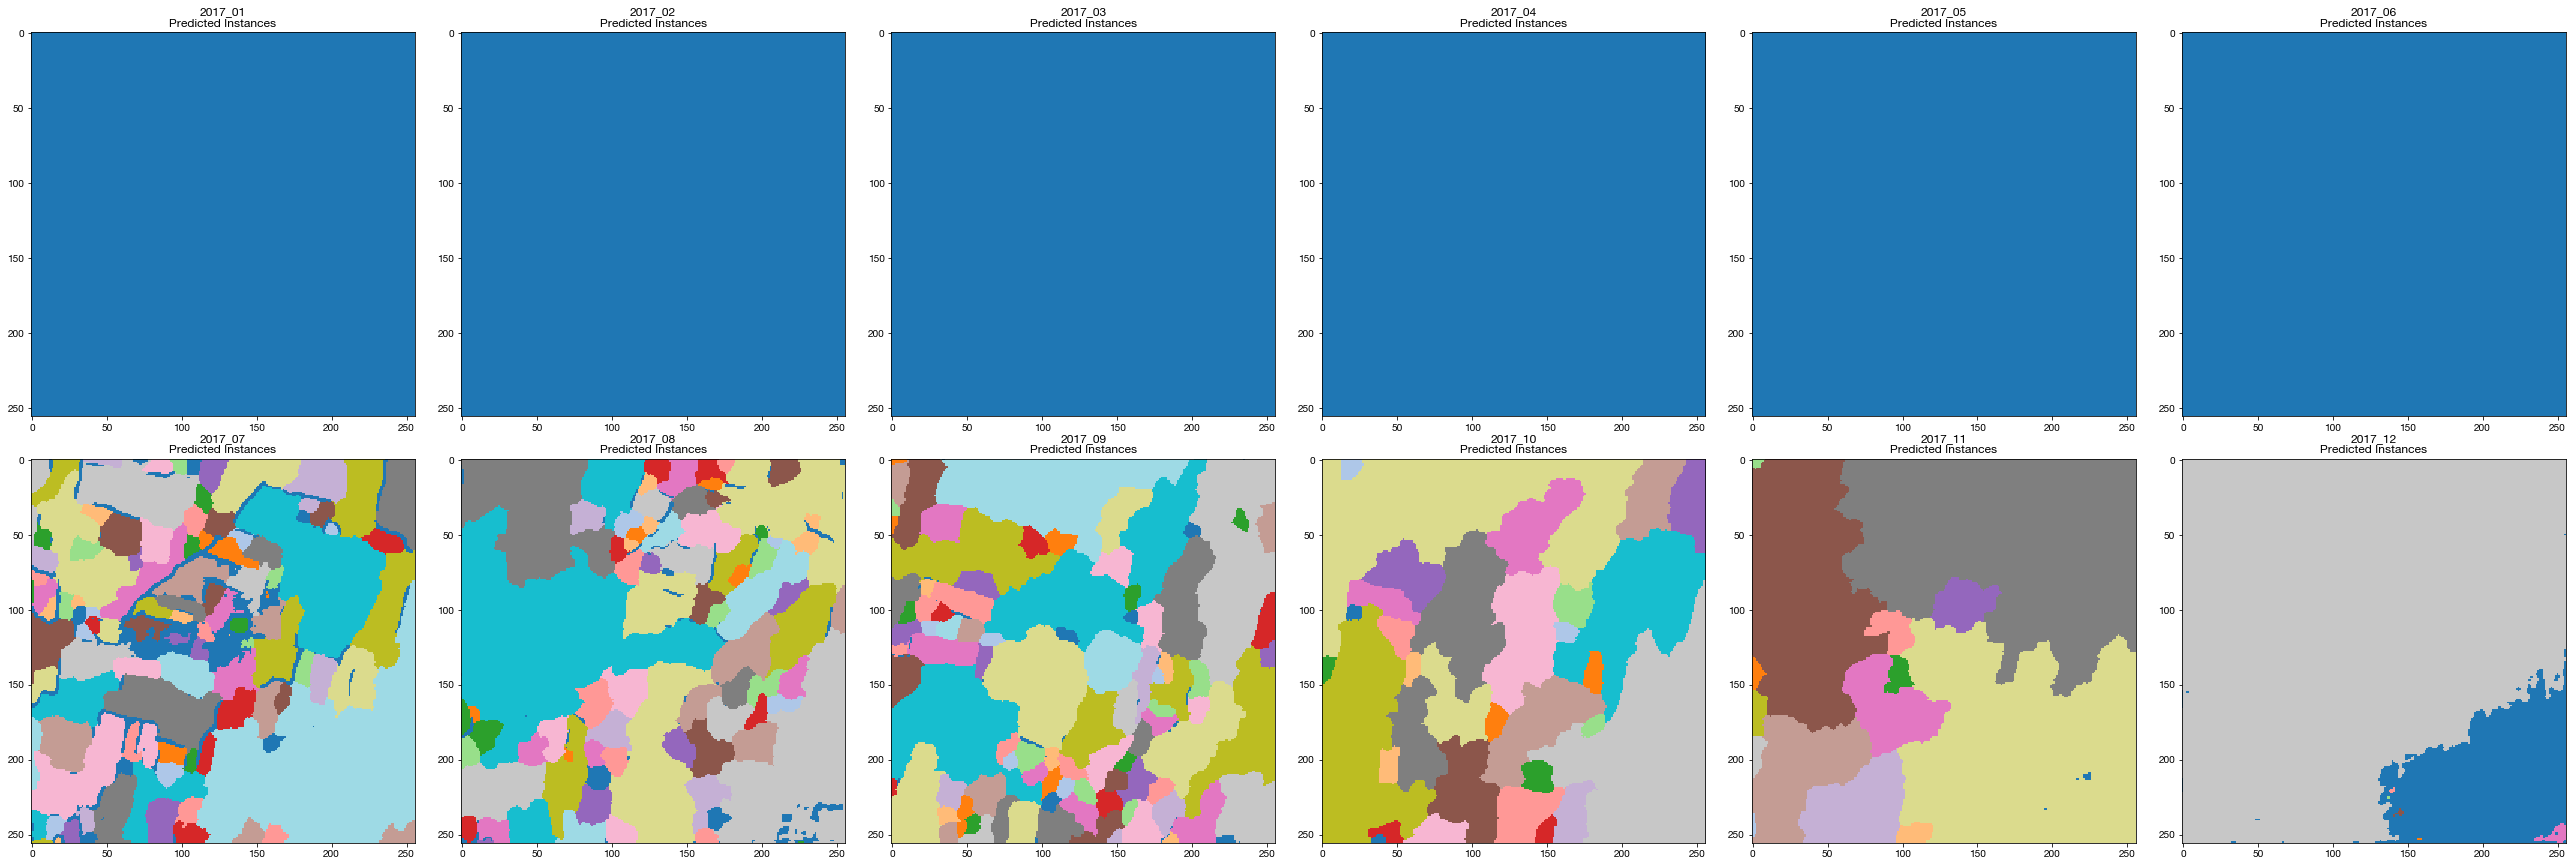

In [5]:
country = 'ghana/udry'
model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_4x-downsampled/'
results_dir = '../results/{}/{}/planet/'.format(country, model_name)
planet_dir = '../data/planet/{}/monthly_mosaics_renamed_clipped_merged/'.format(country)
month_dirs = sorted(os.listdir(planet_dir))
random_image_name = '00005'

t_ext = 0.5
t_bound = 0.1

fig, ax = plt.subplots(2, 6, figsize=(36,12))
for m, month in enumerate(month_dirs):
#     example_img = imageio.imread(os.path.join(image_dir, month, '{}_{}.tif'.format(image_id, month)))[:256,:256,:3]
    example_extent = np.load(os.path.join(results_dir, month, 'extent_predictions/{}.npy'.format(random_image_name)))
    example_boundary = np.load(os.path.join(results_dir, month, 'boundary_predictions/{}.npy'.format(random_image_name)))
    
    instances = InstSegm(example_extent, example_boundary, t_ext=t_ext, t_bound=t_bound)

    # map instances to better range for plotting
    unique_instances = sorted(np.unique(instances))
    n_instances = len(unique_instances)
    instance_map = {x: i for i, x in enumerate(unique_instances)}
    def map_values(x):
        return instance_map[x]
    instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
        instances.shape[0], instances.shape[1])
    
    i = m // 6
    j = m % 6
    ax[i,j].imshow(instances_mapped, vmin=0, vmax=n_instances+1, cmap='tab20')
    ax[i,j].set_title('{}\nPredicted Instances'.format(month))

plt.tight_layout()
plt.show()

## Which month has the best imagery?

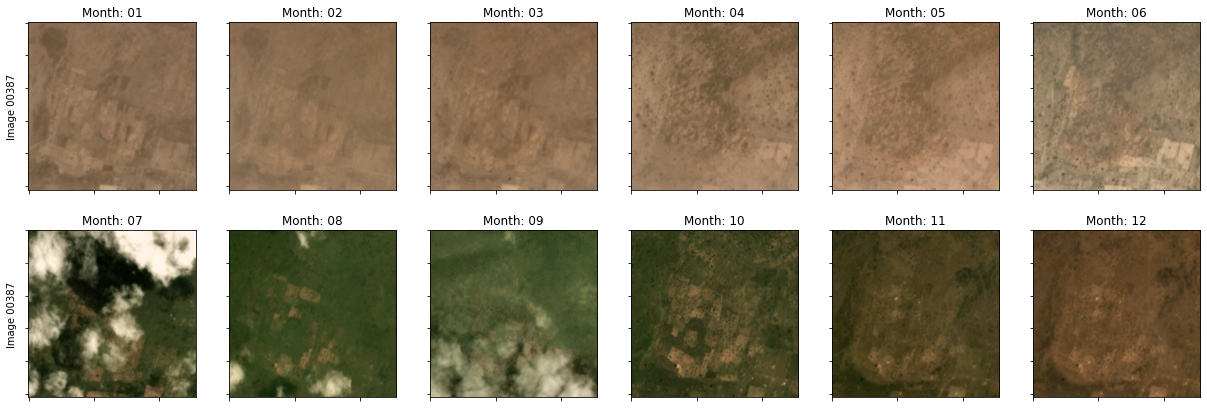

In [22]:
country = 'ghana/udry'
planet_dir = '../data/planet/{}/monthly_mosaics_renamed_clipped_merged/'.format(country)
months = sorted(os.listdir(planet_dir))
img_csv = pd.read_csv('../data/planet/{}/bbox10.csv'.format(country), dtype=str)
img_name = np.random.choice(img_csv['image_id'].values)

ncols = 6
nrows = len(months) // ncols
fig, ax = plt.subplots(nrows, ncols, figsize=(21, 7))
for k, month in enumerate(months):
    i = k // ncols
    j = k % ncols
    img = imageio.imread(os.path.join(planet_dir, month, img_name+'_'+month+'.tif'))
    ax[i,j].imshow(img[:256,:256])
    ax[i,j].set_yticklabels([])
    ax[i,j].set_xticklabels([])
    if j == 0:
        ax[i,j].set_ylabel("Image {}".format(img_name))
    ax[i,j].set_title("Month: {}".format(month.split('_')[-1]))
    
plt.show()